In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import matplotlib.pyplot as plt
import requests

from pathlib import Path
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from torch import nn

torch.__version__

'2.6.0+cu124'

In [3]:
number_features = 2
number_samples = 1000
number_classes = 4

X_blob, y_blob = make_blobs(n_samples=number_samples, n_features=number_features, centers=number_classes)
X_blob[:10], y_blob[:10]

(array([[  0.99045436,  -6.47837969],
        [  7.63480367,  -7.13286167],
        [  0.21592468,  -7.85171301],
        [  9.50102843,   2.62844119],
        [  8.28435032,   5.00509888],
        [ 10.12241605,   1.02547921],
        [-10.01052595,  -1.13890791],
        [  8.12620902,  -6.96328332],
        [  8.76869191,  -6.93879907],
        [  9.14058945,  -5.79827038]]),
 array([3, 1, 3, 0, 0, 0, 2, 1, 1, 1]))

In [4]:
X_sample = X_blob[0]
y_sample = y_blob[0]

print(f'{X_sample} produces {y_sample}')

[ 0.99045436 -6.47837969] produces 3


In [5]:
blobs = pd.DataFrame({
    'X1': X_blob[:, 0],
    'X2': X_blob[:, 1],
    'labels': y_blob
})

blobs.head()

,X1,X2,labels
0,0.990454,-6.478380,3
1,7.634804,-7.132862,1
2,0.215925,-7.851713,3
3,9.501028,2.628441,0
4,8.284350,5.005099,0


In [6]:
blobs.labels.value_counts()

labels
3    250
1    250
0    250
2    250
Name: count, dtype: int64

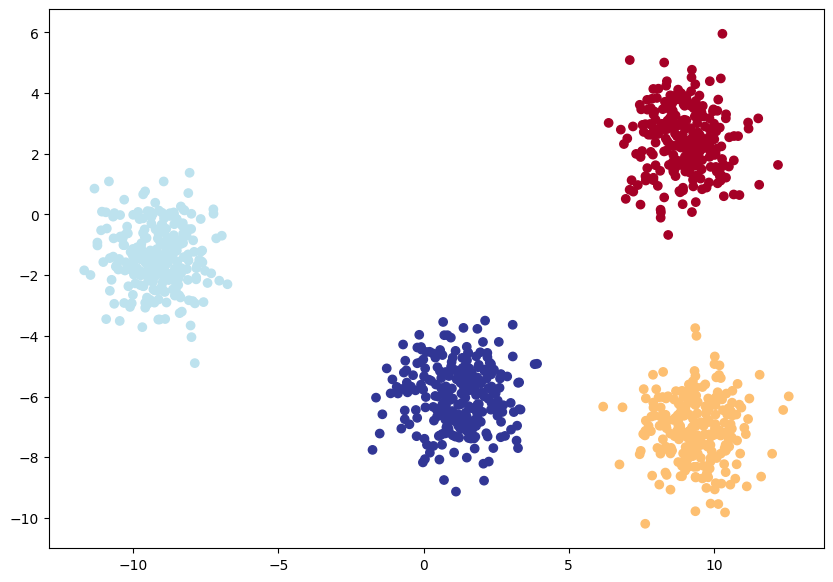

In [7]:
plt.figure(figsize=(10, 7))
plt.scatter(blobs['X1'], blobs['X2'], c=y_blob, cmap=plt.cm.RdYlBu)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_blob,
    y_blob,
    train_size=0.8
)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [9]:
# X_train = torch.from_numpy(X_train).float()
# X_test = torch.from_numpy(X_test).float()
# y_train = torch.from_numpy(y_train).float()
# y_test = torch.from_numpy(y_test).float()

# X_train.type(), X_test.type(), y_train.type(), y_test.type()

In [10]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

X_train.type(), X_test.type(), y_train.type(), y_test.type()

('torch.FloatTensor',
 'torch.FloatTensor',
 'torch.LongTensor',
 'torch.LongTensor')

In [12]:
class MultiClassClassificationModelV0(nn.Module):
    def __init__(self, input_features: int, hidden_units: int, output_features: int):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=output_features)
            
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.nn(x)


model0 = MultiClassClassificationModelV0(input_features=number_features, hidden_units=4, output_features=number_classes)
model0

MultiClassClassificationModelV0(
  (nn): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [13]:
optimizer = torch.optim.SGD(
    params=model0.parameters(),
    lr=0.1
)

criterion = nn.CrossEntropyLoss()

In [14]:
model0(X_train)[:5]

tensor([[ 0.3006, -0.0385,  0.4512, -0.3162],
        [ 0.2669, -0.0353,  0.3583, -0.2991],
        [ 0.3097, -0.0322,  0.4839, -0.3171],
        [ 0.2735, -0.0373,  0.3619, -0.3020],
        [ 0.2927, -0.0339,  0.4509, -0.3085]], grad_fn=<SliceBackward0>)

In [15]:
def accuracy_fn(y_true, y_preds):
    correct = torch.eq(y_true, y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100
    return acc

In [16]:
untrained_logits = model0(X_test)
print(f'Untrained logits length: {len(untrained_logits)} | Untrained logits shape: {untrained_logits.shape}')
print(f'Testing labels length: {len(y_test)} | Testing labels shape: {y_test.shape}')
print(f'First 10 untrained logits: {untrained_logits[:10]}')
print(f'First 10 testing labels: {y_test[:10]}')

Untrained logits length: 200 | Untrained logits shape: torch.Size([200, 4])
Testing labels length: 200 | Testing labels shape: torch.Size([200])
First 10 untrained logits: tensor([[ 0.3307, -0.0101,  0.5829, -0.3297],
        [ 0.3081, -0.0260,  0.4851, -0.3053],
        [ 0.2956, -0.0380,  0.4453, -0.3136],
        [ 0.2446,  0.0414,  0.3925, -0.2677],
        [ 0.2066,  0.0266,  0.3280, -0.2646],
        [ 0.2511, -0.0329,  0.3444, -0.2915],
        [ 0.2696, -0.0377,  0.3562, -0.2996],
        [ 0.2653, -0.0352,  0.3567, -0.2983],
        [ 0.1991,  0.0084,  0.3058, -0.2681],
        [ 0.2271,  0.0279,  0.3601, -0.2664]], grad_fn=<SliceBackward0>)
First 10 testing labels: tensor([1, 1, 1, 3, 3, 0, 0, 0, 2, 3])


In [28]:
untrained_logits_sample = untrained_logits[0]
print(f'Sample set of untrained logits: {untrained_logits_sample}')
print(f'Softmax values: {torch.softmax(untrained_logits_sample, dim=0)}')
print(f'Highest probability: {torch.softmax(untrained_logits_sample, dim=0).argmax(dim=0)}')

Sample set of untrained logits: tensor([ 0.3307, -0.0101,  0.5829, -0.3297], grad_fn=<SelectBackward0>)
Softmax values: tensor([0.2845, 0.2024, 0.3661, 0.1470], grad_fn=<SoftmaxBackward0>)
Highest probability: 2


In [30]:
untrained_logits.shape

torch.Size([200, 4])

In [31]:
untrained_preds = torch.softmax(untrained_logits, dim=1).argmax(dim=1)
print(f'Untrained predictions length: {len(untrained_preds)} | Untrained predictions shape: {untrained_preds.shape}')
print(f'First 10 untrained predictions: {untrained_preds[:10]}')


Untrained predictions length: 200 | Untrained predictions shape: torch.Size([200])
First 10 untrained predictions: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


In [35]:
epochs = 100

for epoch in tqdm(range(epochs)):
    model0.train()

    train_logits = model0(X_train)
    train_preds = torch.softmax(train_logits, dim=1).argmax(dim=1)

    train_loss = criterion(train_logits, y_train)
    train_acc = accuracy_fn(y_train, train_preds)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    model0.eval()
    with torch.inference_mode():
        test_logits = model0(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = criterion(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc : {train_acc:.2f}% | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.2f}%')



  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.36 | Train Acc : 96.75% | Test Loss: 0.34 | Test Acc: 98.00%
Epoch: 10 | Train Loss: 0.33 | Train Acc : 97.62% | Test Loss: 0.31 | Test Acc: 99.50%
Epoch: 20 | Train Loss: 0.30 | Train Acc : 98.25% | Test Loss: 0.28 | Test Acc: 99.50%
Epoch: 30 | Train Loss: 0.27 | Train Acc : 98.38% | Test Loss: 0.25 | Test Acc: 99.50%
Epoch: 40 | Train Loss: 0.24 | Train Acc : 98.88% | Test Loss: 0.23 | Test Acc: 99.50%
Epoch: 50 | Train Loss: 0.23 | Train Acc : 99.25% | Test Loss: 0.22 | Test Acc: 99.50%
Epoch: 60 | Train Loss: 0.21 | Train Acc : 99.00% | Test Loss: 0.19 | Test Acc: 99.00%
Epoch: 70 | Train Loss: 0.19 | Train Acc : 99.38% | Test Loss: 0.17 | Test Acc: 99.00%
Epoch: 80 | Train Loss: 0.17 | Train Acc : 99.75% | Test Loss: 0.15 | Test Acc: 99.50%
Epoch: 90 | Train Loss: 0.15 | Train Acc : 100.00% | Test Loss: 0.13 | Test Acc: 100.00%


In [36]:
if Path('helper_functions.py').is_file():
    print('skipping download...')
else:
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)
    print('Done downloading')

from helper_functions import plot_decision_boundary

skipping download...


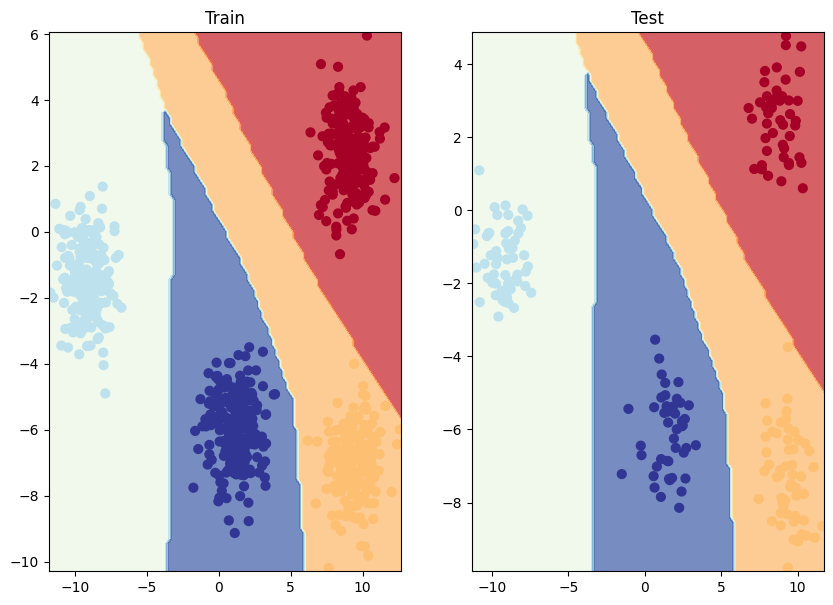

In [37]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model0, X_test, y_test)

In [43]:
try:
    from torchmetrics import Accuracy, ConfusionMatrix
except:
    !pip install torchmetrics==0.9.3
    from torchmetrics import Accuracy, ConfusionMatrix

In [39]:
model0.eval()
with torch.inference_mode():
    y_logits = model0(X_test)

y_logits[:5]

tensor([[ 3.5353,  5.4696, -3.2098, -2.9085],
        [ 1.3155,  3.6502, -2.1683, -1.0065],
        [ 4.0351,  5.7105, -3.4648, -3.2974],
        [-1.6709,  0.1907, -0.2128,  1.9590],
        [-1.6709,  0.1907, -0.2128,  1.9590]])

In [40]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)
y_preds[:5]

tensor([1, 1, 1, 3, 3])

In [41]:
y_test[:5]

tensor([1, 1, 1, 3, 3])

In [42]:
accuracy = Accuracy(task='multiclass', num_classes=number_classes)
accuracy(y_preds, y_test)

tensor(1.)

In [45]:
confmat = ConfusionMatrix(task='multiclass', num_classes=number_classes)
confmat(y_preds, y_test)

tensor([[47,  0,  0,  0],
        [ 0, 54,  0,  0],
        [ 0,  0, 55,  0],
        [ 0,  0,  0, 44]])